# mmclassification Need to write custom dataset class

In [ ]:
import os
import mmcls
print(mmcls.__version__)

In [ ]:
data_dir = '/home/umi/projects/WorkoutDetector/datasets/haa500_small'
train_dir = os.path.join(data_dir, 'train-img')
val_dir = os.path.join(data_dir, 'val-img')
train_txt = os.path.join(data_dir, 'train-img.txt')
val_txt = os.path.join(data_dir, 'val-img.txt')

In [ ]:
from PIL import Image
Image.open(os.path.join(train_dir, 'battle-rope_wave_000_1.png'))


In [2]:
mmcls_path = os.path.dirname(mmcls.__path__[0])
ckpt_name = 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth'
config_file = os.path.join(mmcls_path, 'configs/mobilenet_v2/mobilenet_v2_b32x8_imagenet.py')
checkpoint_file = ckpt_name
print(checkpoint_file)

NameError: name 'mmcls' is not defined

In [ ]:
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot
device = 'cuda:0'

# Build the model according to the config file and load the checkpoint.
model = init_model(config_file, checkpoint_file, device=device)

In [1]:
# Load the base config file
from mmcv import Config
cfg = Config.fromfile(config_file)
# Modify the number of classes in the head.
cfg.model.head.num_classes = 16
cfg.model.head.topk = (1, )

# Load the pre-trained model's checkpoint.
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 2

# Specify the path and meta files of training dataset
cfg.data.train.data_prefix = './datasets/haa500_small/train-img'
cfg.data.train.classes = 'datasets/haa500_small/train-img.txt'

# Specify the path and meta files of validation dataset
cfg.data.val.data_prefix = 'datasets/haa500_small/val-img'
cfg.data.val.ann_file = 'datasets/haa500_small/val-img.txt'
cfg.data.val.classes = 'datasets/haa500_small/class.txt'

# Specify the path and meta files of test dataset
cfg.data.test.data_prefix = 'datasets/haa500_small/val-img'
cfg.data.test.ann_file = 'datasets/haa500_small/val-img.txt'
cfg.data.test.classes = 'datasets/haa500_small/class.txt'

# Specify the normalization parameters in data pipeline
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# Modify the evaluation metric
cfg.evaluation['metric_options']={'topk': (1, )}

# Specify the optimizer
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Specify the learning rate scheduler
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=2)

# Specify the work directory
cfg.work_dir = './work_dirs/haa500_small_dataset'

# Output logs for every 10 iterations
cfg.log_config.interval = 10



# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)

NameError: name 'config_file' is not defined

In [ ]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# Create the work directory
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# Build the classifier
model = build_classifier(cfg.model)
model.init_weights()
# Build the dataset
datasets = [build_dataset(cfg.data.train)]
# Add `CLASSES` attributes to help visualization
model.CLASSES = datasets[0].CLASSES
# Start fine-tuning
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

# Pytorch

In [20]:
import matplotlib.pyplot as plt
import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torchvision import datasets, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [4]:
data_transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets/haa500_small'

class Mydataset(Dataset):
    def __init__(self, data_dir, train=True, transform=False):
        self.data_dir = data_dir
        self.transform = transform
        if train:
            self.data_transforms = data_transforms['train']
            label_txt = os.path.join(data_dir, 'train-img.txt') 
        else:
            self.data_transforms = data_transforms['val']
            label_txt = os.path.join(data_dir, 'val-img.txt')
        annos = None
        with open(label_txt, 'r') as f:
            annos = f.readlines()
        annos = [label.strip() for label in annos]
        self.imgs, self.labels = zip(*[[label.split(' ')[0], label.split(' ')[1]] for label in annos])
        self.labels = [int(label) for label in self.labels]

        with open(os.path.join(data_dir, 'class.txt'), 'r') as f:
            self.classes = f.readlines()
        self.classes = [label.strip() for label in self.classes]
        self.classes = dict(enumerate([c.split()[0] for c in self.classes]))
        
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.imgs[idx])
        img = T.ToPILImage()(read_image(img_path))
        if self.transform:
            img = self.data_transforms(img)
        label = self.labels[idx]
        classname = self.classes[int(label)]
        return img, label, classname


In [75]:
train_set = Mydataset(data_dir, train=True, transform=True)
val_set = Mydataset(data_dir, train=False, transform=True)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)
class_names = train_set.classes
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_set), 'val': len(val_set)}

torch.Size([4, 3, 224, 224]) tensor([11,  5,  6,  1]) ('pushup', 'gym_plank', 'gym_pull', 'bench_dip')


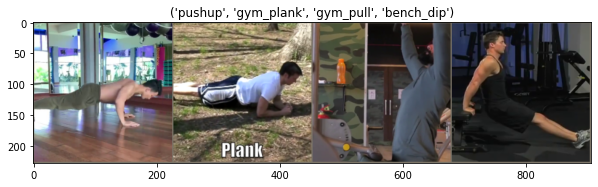

In [103]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(10,5))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels, classes = next(iter(dataloaders['val']))
print(inputs.shape, labels, classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [113]:
def visualize_model(model, num_batch=2):
    was_training = model.training
    model.eval()
    num_row = num_batch*2
    fig, axes = plt.subplots(num_row, 2, figsize=(10, 10), dpi=200)
    with torch.no_grad():
        for i in range(num_row):
            inputs, labels, classnames = next(iter(dataloaders['val']))
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.to('cpu').data.numpy()
            labels = labels.to('cpu').data.numpy()
            inputs = inputs.to('cpu')
            correct = np.squeeze(preds == labels)
            color = ['green' if correct[j] else 'red' for j in range(num_batch)]
            for j in range(2):
                ax = axes[i, j]
                ax.axis('off')
                ax.set_title(f'pred={class_names[preds[j]]}, true={class_names[labels[j]]}', color=color[j])
                inp = inputs[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

        model.train(mode=was_training)

In [22]:
model_ft = models.resnet18(pretrained=True)
# for param in model_ft.parameters():
#     param.requires_grad = False
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [117]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25
train Loss: 0.3166 Acc: 0.9037
val Loss: 2.2614 Acc: 0.4981
Epoch 2/25
train Loss: 0.3815 Acc: 0.8943
val Loss: 2.3258 Acc: 0.4847
Epoch 3/25
train Loss: 0.3898 Acc: 0.8788
val Loss: 2.3317 Acc: 0.4885
Epoch 4/25
train Loss: 0.4141 Acc: 0.8888
val Loss: 2.3092 Acc: 0.4770
Epoch 5/25
train Loss: 0.3819 Acc: 0.8894
val Loss: 2.2940 Acc: 0.4693
Epoch 6/25
train Loss: 0.3533 Acc: 0.8987
val Loss: 2.4503 Acc: 0.4732
Epoch 7/25
train Loss: 0.3555 Acc: 0.8962
val Loss: 2.3639 Acc: 0.4789
Epoch 8/25
train Loss: 0.3352 Acc: 0.9068
val Loss: 2.3410 Acc: 0.4828
Epoch 9/25
train Loss: 0.3356 Acc: 0.9018
val Loss: 2.2736 Acc: 0.4943
Epoch 10/25
train Loss: 0.3495 Acc: 0.9024
val Loss: 2.3305 Acc: 0.4713
Epoch 11/25
train Loss: 0.4091 Acc: 0.8788
val Loss: 2.4639 Acc: 0.4828
Epoch 12/25
train Loss: 0.3554 Acc: 0.9012
val Loss: 2.3117 Acc: 0.4885
Epoch 13/25
train Loss: 0.3194 Acc: 0.9105
val Loss: 2.2553 Acc: 0.5000
Epoch 14/25
train Loss: 0.3527 Acc: 0.9006
val Loss: 2.2785 Acc: 0.4636
E

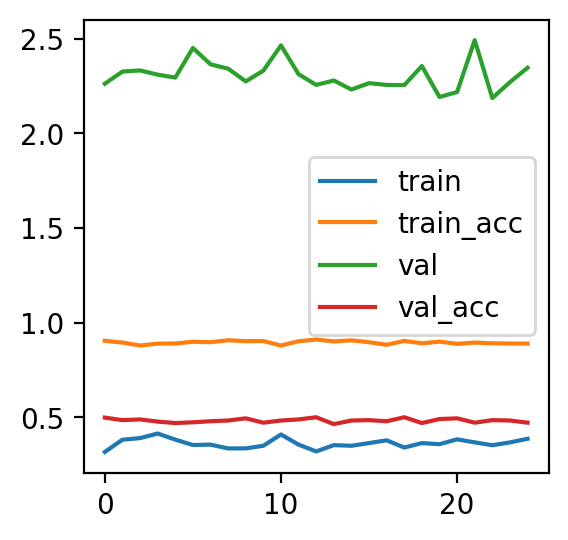

In [130]:
plt.figure(dpi=200, figsize=(3,3))
plt.plot(history['train_loss'], label='train')
plt.plot([d.to('cpu').data for d in history['train_acc']], label='train_acc')
plt.plot(history['val_loss'], label='val')
plt.plot([d.to('cpu').data for d in history['val_acc']], label='val_acc')
plt.legend()
plt.show()


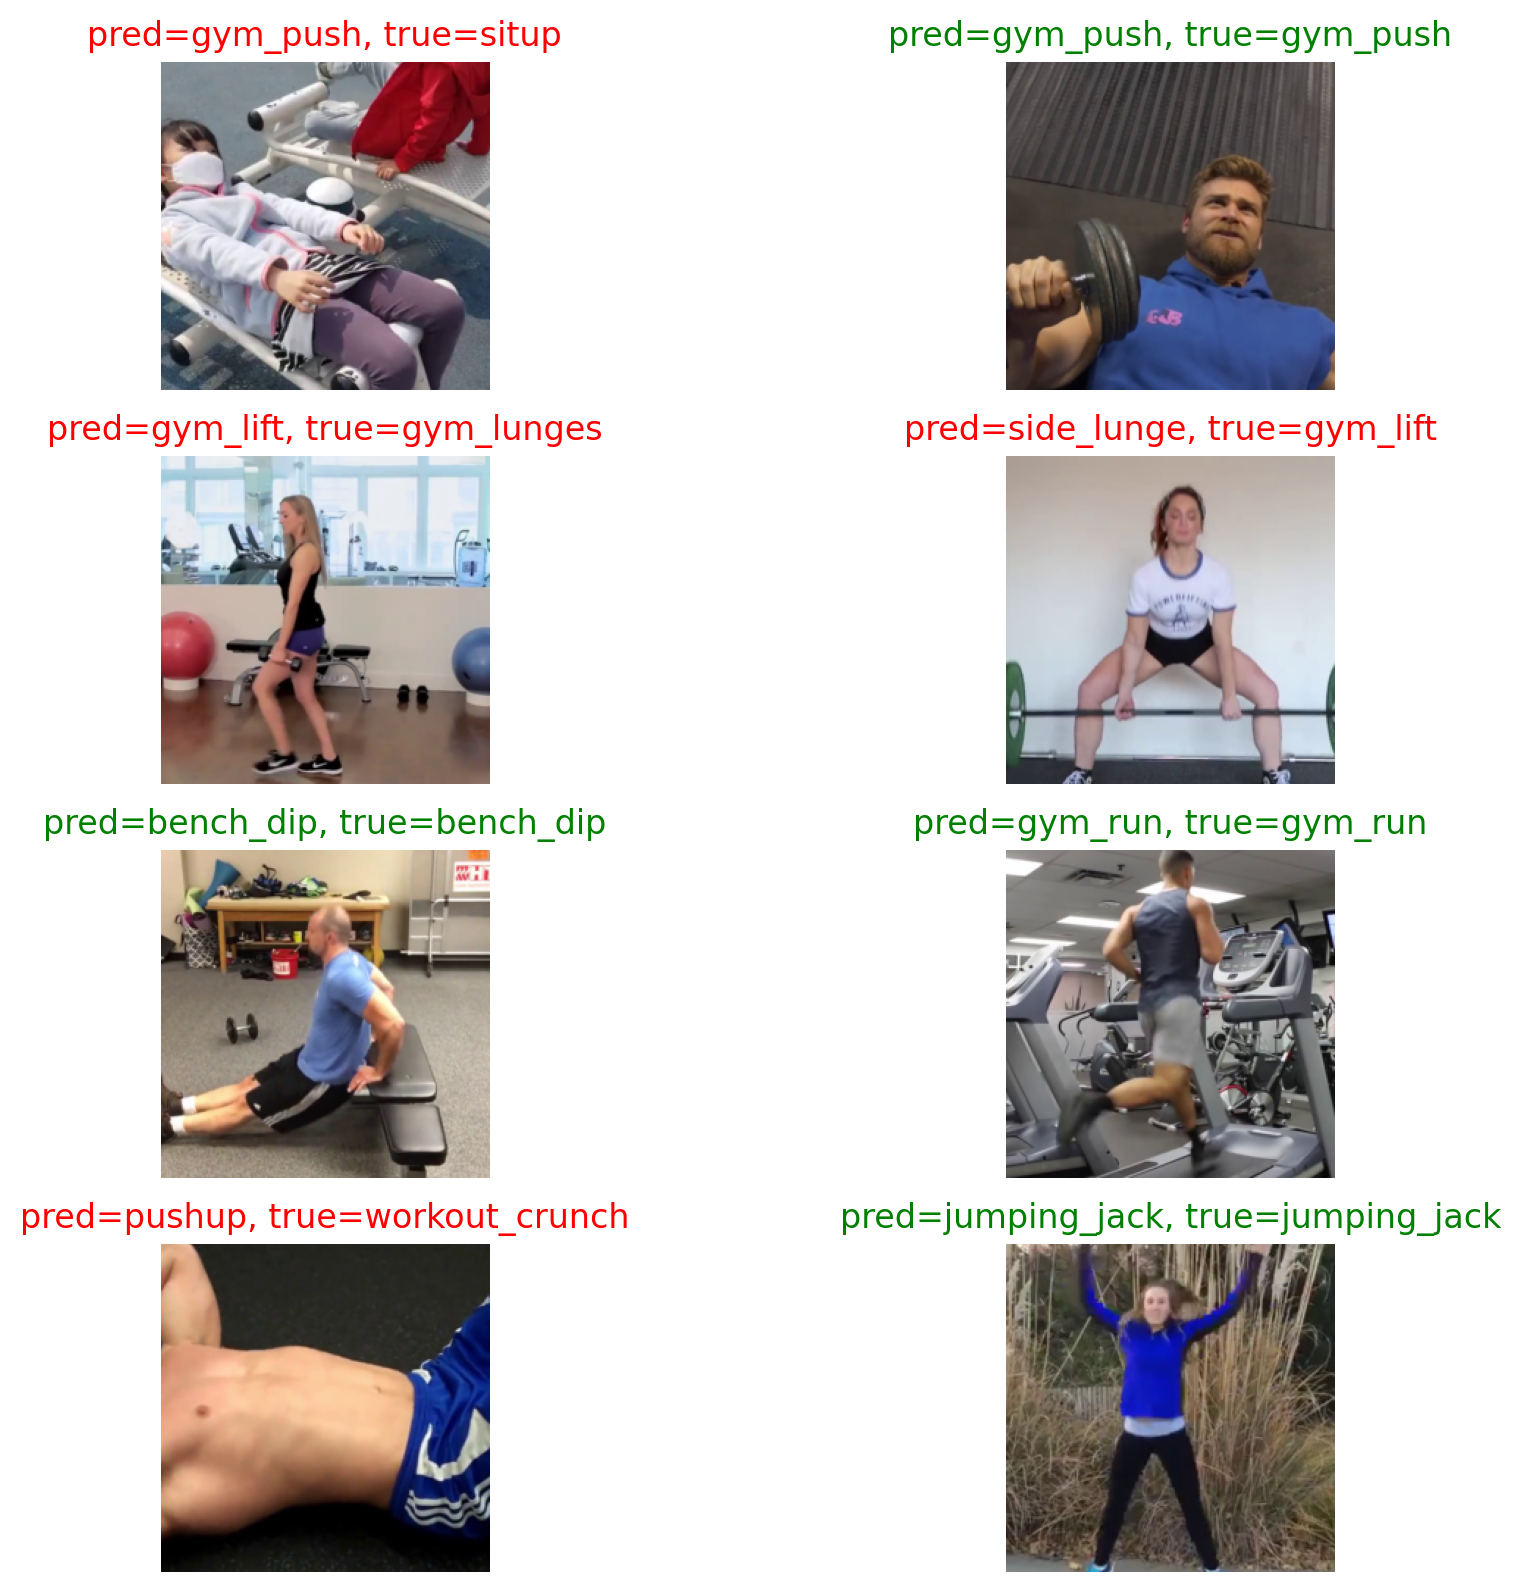

In [116]:
visualize_model(model_ft)